<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/Yutong_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import warnings

In [2]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


In [3]:
# The result is a series where the index is 'patient_nbr' and the value is the count of records.
patients_with_2_or_more_records = (data.groupby('Patient_ID').apply(len) >= 2)

# Filter the original dataset to include only those patients who have 2 or more records.
patients_with_2_or_more_records_df = data[data['Patient_ID'].isin(patients_with_2_or_more_records[patients_with_2_or_more_records].index)]

# Update the original 'diabetes_data' dataframe with the filtered dataframe.
data = patients_with_2_or_more_records_df

data.shape

(2497, 43)

In [4]:
# The maximum number of visits for patients
data.groupby(['Patient_ID']).size().max()

8

In [5]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

# Create a subset with no date
df = data[['Patient_ID', 'Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']

<ipython-input-5-30218cad7ea4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
<ipython-input-5-30218cad7ea4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)
<ipython-input-5-30218cad7ea4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Use_of_Hyper

In [6]:
# Grouping by 'Patient_ID' and creating a list of dataframes, one per group
grouped = df.groupby('Patient_ID')
grouped_dfs = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((2017, 16), (480, 16))

In [7]:
# Normalizing data
scaler = StandardScaler()

train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

In [31]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
train_filled_mice = pd.DataFrame(imputer.fit_transform(train_df), columns = train_df.columns)
test_filled_mice = pd.DataFrame(imputer.transform(test_df), columns = test_df.columns)

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Group by 'patient_nbr' and create sequences
grouped = train_filled_mice.groupby('Patient_ID', sort=False)
sequences = [group.drop(columns=['Patient_ID', 'DIABETES']).values for _, group in grouped]
targets = [group['DIABETES'].iloc[-1] for _, group in grouped]  # Assuming all records for a patient have the same target

# Padding sequences
max_length = max(len(s) for s in sequences)
# We cal also go with max_length
padded_sequences = pad_sequences(sequences, maxlen=8, padding='post', dtype='float')

padded_sequences.shape

(879, 8, 14)

In [33]:
#Testing sequences

# Group by 'patient_nbr' and create sequences
grouped_test = test_df.groupby('Patient_ID', sort=False)
sequences_test = [group.drop(columns=['Patient_ID', 'DIABETES']).values for _, group in grouped_test]
targets_test = [group['DIABETES'].iloc[-1] for _, group in grouped_test]  # Assuming all records for a patient have the same target

# Padding sequences for the test set
padded_sequences_test = pad_sequences(sequences_test, maxlen=8, padding='post', dtype='float')

padded_sequences_test.shape

(220, 8, 14)

In [39]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
input_size = padded_sequences.shape[2]
hidden_size = 5  # Number of hidden units in RNN
num_classes = 1
epochs = 1000
learning_rate = 0.001
batch_size = 50
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(padded_sequences, dtype=t.float32), t.tensor(targets, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(padded_sequences_test, dtype=t.float32), t.tensor(targets_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
# rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
# dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, 1)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
tanh = nn.Tanh()
sigmoid = nn.Sigmoid()

# Loss function and optimizer
loss_fn = nn.BCELoss()
# optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 10 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        # out, _ = rnn_layer2(out)
        # out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = tanh(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)
        out = sigmoid(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out.view(-1), Y.float())

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    # rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = tanh(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            probs = sigmoid(out)
            predicted = (probs >= 0.5).type(t.LongTensor).view(-1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = tanh(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            probs = sigmoid(out)
            predicted = (probs >= 0.5).type(t.LongTensor).view(-1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()


Epoch 0/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 1/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 2/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 3/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 4/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 5/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 6/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 7/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 8/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 9/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 10/1000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 11/1000 ---> Train Accuracy: 69.73833902161547%, Validation Accuracy: 70.0%
Epoch 12/1000 ---> Train A

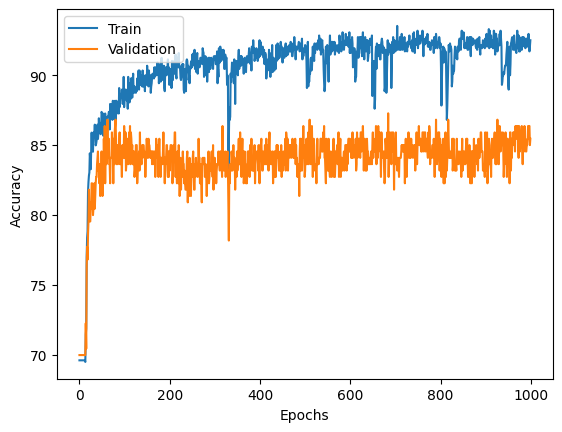

In [38]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()